# Object Detection of Rectangles or Triangles
Localize the rectangles or triangles, then classify them.

The notebook program is modified based on object detection with neural networks — a simple tutorial using keras by Johannes Rieke.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Create images with random rectangles or triangles with bounding boxes. 

In [2]:
num_imgs = 50000

img_size = 16
min_rect_size = 3
max_rect_size = 8
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))
shapes = np.zeros((num_imgs, num_objects, 1))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        if np.random.choice([True, False]):
            width, height = np.random.randint(min_rect_size, max_rect_size, size=2)
            x = np.random.randint(0, img_size - width)
            y = np.random.randint(0, img_size - height)
            imgs[i_img, x:x+width, y:y+height] = 1.
            bboxes[i_img, i_object] = [x, y, width, height]
            shapes[i_img, i_object] = [0]
        else:
            size = np.random.randint(min_rect_size, max_rect_size)
            x, y = np.random.randint(0, img_size - size, size=2)
            mask = np.tril_indices(size)
            imgs[i_img, x + mask[0], y + mask[1]] = 1.
            bboxes[i_img, i_object] = [x, y, size, size]
            shapes[i_img, i_object] = [1]
        
imgs.shape, bboxes.shape

((50000, 16, 16), (50000, 2, 4))

In [3]:
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 256), -1.1833811708328313e-16, 0.9999999999999998)

In [4]:
# TODO: We use binary classification here - for multiple classes, convert classes to one-hot vectors.
y = np.concatenate([bboxes / img_size, shapes], axis=-1).reshape(num_imgs, -1)
y.shape

(50000, 10)

### Model Input and Output
Input: normalized image
Output: bounding box (bx1, by1, bw1, bh1, c1, bx2, by2, bw2, bh2, c2)

In [5]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

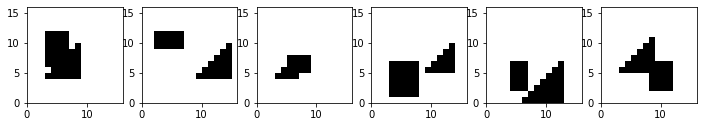

In [6]:
# i = 0
# # TODO: Why does the array have to be transposed?
# plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
# for bbox, shape in zip(bboxes[i], shapes[i]):
#     plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r' if shape[0] == 0 else 'y', fc='none'))
#     if shape[i] == 0:
#         plt.annotate('rectangle', (bbox[0], bbox[1]+bbox[3]+0.2), color='r')
#     else:
#         plt.annotate('triangle', (bbox[0], bbox[1]+bbox[3]+0.2), color='y')
plt.figure(figsize=(12, 3))
for i in range(1, 7):
    plt.subplot(1, 6, i)
    plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
plt.show()

In [7]:
# # i = 0
# # # TODO: Why does the array have to be transposed?
# # plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
# # for bbox, shape in zip(bboxes[i], shapes[i]):
# #     plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r' if shape[0] == 0 else 'y', fc='none'))

# plt.figure(figsize=(12, 3))
# for i_subplot in range(1, 5):
#     plt.subplot(1, 4, i_subplot)
#     i = np.random.randint(len(test_X))
#     plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
#     for bbox in bboxes[i]:
#         plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

### Build the model.

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile(Adam(0.0002, beta_1=0.5), 'mse')

In [9]:
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]  # TODO: Check if its more performant if tensor elements are accessed directly below.
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    w_I = max(w_I, 0)  # set w_I and h_I zero if there is no intersection
    h_I = max(h_I, 0)
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

### Training with Flipping

In [10]:
num_epochs = 30
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious = np.zeros((len(flipped_train_y), num_epochs))
dists = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[5:], exp_bboxes[:5]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
#         iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
#         iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
#         dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
#         dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])

        iou = IOU(pred_bboxes[:5], exp_bboxes[:5]) + IOU(pred_bboxes[5:], exp_bboxes[5:])
        iou_flipped = IOU(pred_bboxes[:5], flipped_exp_bboxes[:5]) + IOU(pred_bboxes[5:], flipped_exp_bboxes[5:])
        
        dist = distance(pred_bboxes[:5], exp_bboxes[:5]) + distance(pred_bboxes[5:], exp_bboxes[5:])
        dist_flipped = distance(pred_bboxes[:5], flipped_exp_bboxes[:5]) + distance(pred_bboxes[5:], flipped_exp_bboxes[5:])
        
        if mse_flipped < mse:  # using iou or dist here leads to similar results
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            ious[i, epoch] = iou_flipped / 2.
            dists[i, epoch] = dist_flipped / 2.
        else:
            ious[i, epoch] = iou / 2.
            dists[i, epoch] = dist / 2.
            
    print('Flipped {} training samples ({} %)'.format(np.sum(flipped[:, epoch]), np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists[:, epoch])))
    print()

Epoch 0
Train on 40000 samples, validate on 10000 samples
40000/40000 - 3s - loss: 0.2253 - val_loss: 0.0672
Flipped 19624.0 training samples (49.059999999999995 %)
Mean IOU: 0.176416254049187
Mean dist: 0.2138982646936504

Epoch 1
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0660 - val_loss: 0.0585
Flipped 6639.0 training samples (16.5975 %)
Mean IOU: 0.2200551953311205
Mean dist: 0.19932399480983093

Epoch 2
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0540 - val_loss: 0.0556
Flipped 5650.0 training samples (14.124999999999998 %)
Mean IOU: 0.24761252109701576
Mean dist: 0.1903020385033601

Epoch 3
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0471 - val_loss: 0.0546
Flipped 5050.0 training samples (12.625 %)
Mean IOU: 0.27287609412005726
Mean dist: 0.1802566411658928

Epoch 4
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0422 - val_loss: 0.0542
Flipped 4046.0 

Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0205 - val_loss: 0.0586
Flipped 691.0 training samples (1.7274999999999998 %)
Mean IOU: 0.47691030350856944
Mean dist: 0.09905210940371519

Epoch 29
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0203 - val_loss: 0.0589
Flipped 778.0 training samples (1.9449999999999998 %)
Mean IOU: 0.4738531277695326
Mean dist: 0.09963677317557272



### Results

Text(0, 0.5, 'Training sample')

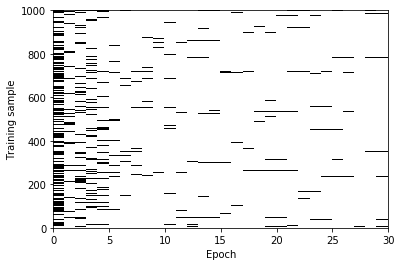

In [11]:
plt.pcolor(flipped[:1000], cmap='Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')

(0, 1)

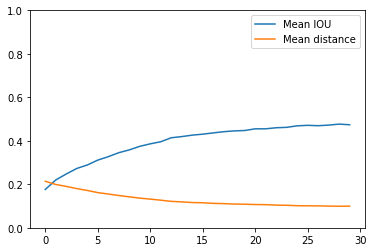

In [12]:
plt.plot(np.mean(ious, axis=0), label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(np.mean(dists, axis=0), label='Mean distance')  # relative to image size
plt.legend()
plt.ylim(0, 1)

In [13]:
pred_y = model.predict(test_X)
pred_y = pred_y.reshape(len(pred_y), num_objects, -1)
pred_bboxes = pred_y[..., :4] * img_size
pred_shapes = pred_y[..., 4:5]
pred_bboxes.shape, pred_shapes.shape

((10000, 2, 4), (10000, 2, 1))

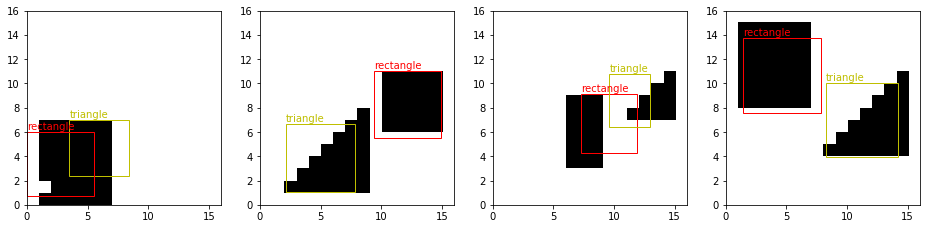

In [14]:
plt.figure(figsize=(16, 8))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox, pred_shape in zip(pred_bboxes[i], test_bboxes[i], pred_shapes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r' if pred_shape[0] <= 0.5 else 'y', fc='none'))
        # TODO: Calculate max IOU with all expected bounding boxes.
#         plt.annotate('IOU: {:.2f}'.format(IOU(pred_bbox, exp_bbox)), (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.4), color='r')
        if pred_shape[0] <0.5:
            plt.annotate('rectangle', (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='r')
        else:
            plt.annotate('triangle', (pred_bbox[0], pred_bbox[1]+pred_bbox[3]+0.2), color='y')
# plt.savefig('plots/bw-two-rectangles-or-triangles4.png', dpi=300)